# Setup

In [10]:
%load_ext autoreload
%autoreload 2

import crispr as cr
from crispr.class_sc import Omics
from anndata import AnnData
import scanpy as sc
import copy

col_sample_id = "orig.ident"
kws_harmony = {"plot_convergence": True, "random_state": 1618}
col_guide_rna = "feature_call"
col_num_umis = "num_umis"
guide_split = "-"
key_control_patterns = ["CTRL"]
key_control = "NT"
feature_split = "|"
min_n_target_control_drop = None
max_pct_control_drop = 75
min_pct_dominant = 80
min_pct_avg_n = 40
remove_multi_transfected = True
col_guide_rna_new = "target_gene_name"
conserve_memory = False

kws_process_guide_rna = {"feature_split": "|", "guide_split": "-", 
                         "key_control_patterns": ["CTRL"],
                         "remove_multi_transfected": True}
kws_process_guide_rna.update(dict(
    min_n_target_control_drop=min_n_target_control_drop,
    max_pct_control_drop=max_pct_control_drop, 
    min_pct_dominant=min_pct_dominant, min_pct_avg_n=min_pct_avg_n,
    remove_multi_transfected=remove_multi_transfected,))
kws_init = {"assay": None, "assay_protein": None, 
            "col_gene_symbols": "gene_symbols", 
            "col_cell_type": "majority_voting", 
            "col_sample_id": col_sample_id, 
            "key_control": "NT", "key_treatment": "KD",
            "col_condition": col_guide_rna_new}  # initialization arguments
kws_crispr = {
    "kws_process_guide_rna": kws_process_guide_rna,
    "col_guide_rna": "feature_call", "col_num_umis": "num_umis", 
    "col_perturbed": "perturbation"}  # CRISPR initialization arguments
kws_umap = {"min_dist": 0.3}
kws_pp = {"kws_hvg": {"min_mean": 0.0125, "max_mean": 10, 
                      "min_disp": 0.5, "flavor": "cell_ranger"}, 
          "target_sum": 10000.0, 
          "cell_filter_pmt": [0, 15], 
          "cell_filter_ngene": [200, 7000], 
          "cell_filter_ncounts": [500, 60000], 
          "gene_filter_ncell": [3, None], 
          "kws_scale": "z",
          "regress_out": None, "kws_umap": kws_umap}
kws_cluster = {"method_cluster": "leiden", "kws_umap": kws_umap, 
               "kws_neighbors": None, 
               "kws_pca": {"n_comps": 20, "use_highly_variable": True}, 
               "resolution": 1.2, "kws_cluster": {}}
file_path = {"HH03": {"directory": "data/crispr-screening/HH03"}, 
             "HH04": {"directory": "data/crispr-screening/HH04"},
             "HH05": {"directory": "data/crispr-screening/HH05"},
             "HH06": {"directory": "data/crispr-screening/HH06"},
             "CR4": {"directory": "data/crispr-screening/HH-Hu-CR4"},
             "CR5": {"directory": "data/crispr-screening/HH-Hu-CR5"}}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create Integrated Object

We first have to create preprocessed and clustered individual objects, then integrate them with Harmony.

## Integrate Data

If `kws_pp` and/or `kws_cluster` = None, then preprocessing and/or clustering, respectively, will not be performed on individual objects.

## Create Overall Object



<<< INITIALIZING OMICS CLASS OBJECT >>>

Unused keyword arguments: {'kws_process_guide_rna': {'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'key_control': 'NT', 'col_guide_rna_new': 'target_gene_name', 'feature_split': '|', 'guide_split': '-', 'key_control_patterns': ['CTRL'], 'remove_multi_transfected': True, 'min_n_target_control_drop': None, 'max_pct_control_drop': 75, 'min_pct_dominant': 80, 'min_pct_avg_n': 40}}.

col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="orig.ident"
col_batch="orig.ident"
col_subject=None
col_condition="target_gene_name"
col_num_umis="num_umis"
key_control="NT"
key_treatment="KD"


<<< INITIALIZING OMICS CLASS OBJECT >>>

Unused keyword arguments: {'kws_process_guide_rna': {'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'key_control': 'NT', 'col_guide_rna_new': 'target_gene_name', 'feature_split': '|', 'guide_split': '-', 'key_control_patterns': ['CTRL'], 'remove_multi_transfected': True, 'min_n_target_co

                    num_features  \
AAACCCAAGAATTTGG-1           6.0   
AAACCCAAGATTTGCC-1           2.0   
AAACCCAAGCGATTCT-1           3.0   
AAACCCAAGTCGGGAT-1           NaN   
AAACCCAAGTCTGCAT-1           6.0   
...                          ...   
TTTGTTGGTTGCCGAC-1           4.0   
TTTGTTGTCACTGTTT-1           2.0   
TTTGTTGTCAGACCCG-1           NaN   
TTTGTTGTCAGTGTGT-1           5.0   
TTTGTTGTCCACGTCT-1           NaN   

                                                feature_call_original  \
AAACCCAAGAATTTGG-1  RASGRP1-1|PAF1-1|NEG_CTRL-2-1|NRBP1-2|RASGRP1-...   
AAACCCAAGATTTGCC-1                                    SNX17-1|SNX17-2   
AAACCCAAGCGATTCT-1                           SP110-1|HLA-B-1|SP140L-2   
AAACCCAAGTCGGGAT-1                                                NaN   
AAACCCAAGTCTGCAT-1    RSBN1-1|PRDX6-1|STK11-1|RSBN1-2|PRDX6-2|NR4A1-2   
...                                                               ...   
TTTGTTGGTTGCCGAC-1                    DUSP1-1|PPARA-1|TA

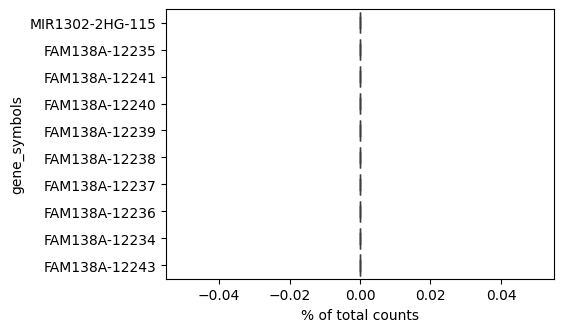



Cell Counts: Initial

3632


Gene Counts: Initial

None 

 10 

        gene_symbols         gene_ids    feature_types
count         36717            36717            36717
unique        36717                2                1
top         FAM138A  ENSG00000237613  Gene Expression
freq              1            36601            36717 



<<< PERFORMING QUALITY CONTROL ANALYSIS>>>

	*** Detecting Mitochondrial, Ribosomal, Hemoglobin genes...

	*** Calculating & plotting QC metrics...




... storing 'feature_call_original' as categorical
... storing 'num_umis_original' as categorical
... storing 'feature_call' as categorical
... storing 'num_umis' as categorical
... storing 'target_gene_name' as categorical
... storing 'guide_split' as categorical
... storing 'gene_ids' as categorical
... storing 'feature_types' as categorical


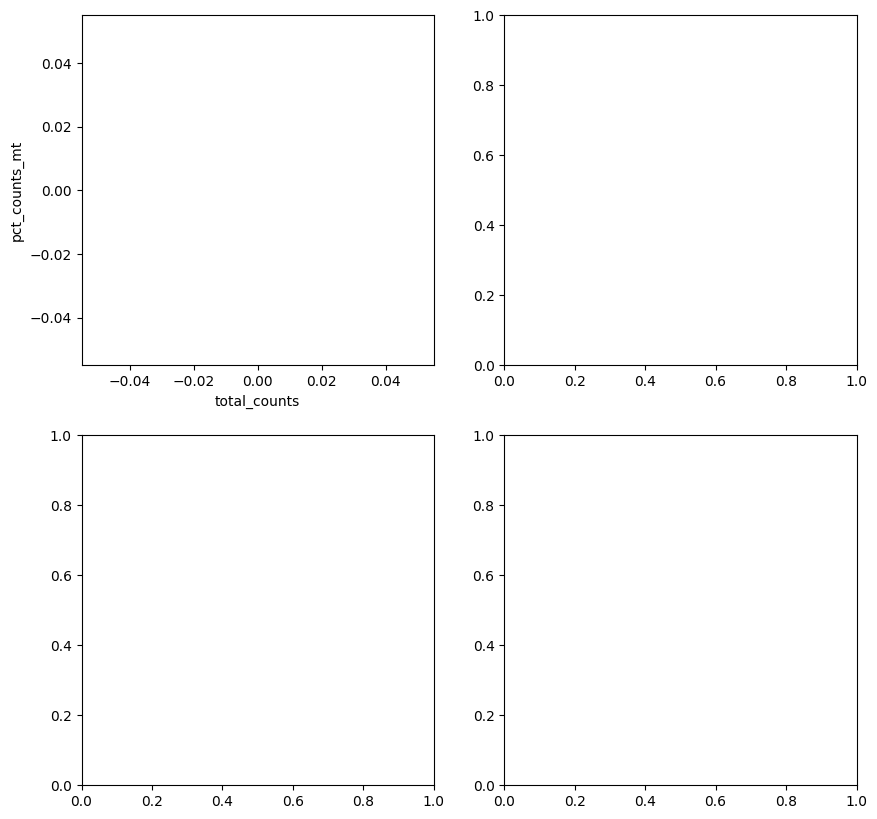

Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/crispr/crispr/processing/preprocessing.py", line 518, in perform_qc
    figs["pct_counts_kde"] = seaborn.displot(
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/seaborn/distributions.py", line 2143, in displot
    g = FacetGrid(
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/seaborn/axisgrid.py", line 462, in __init__
    axes = fig.subplots(nrow, ncol, **kwargs)
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/matplotlib/figure.py", line 930, in subplots
    gs = self.add_gridspec(nrows, ncols, figure=self, **gridspec_kw)
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/matplotlib/figure.py", line 1542, in add_gridspec
    gs = GridSpec(nrows=nrows, ncols=ncols, figure=self, **kwargs)
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-package

ValueError: Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required.

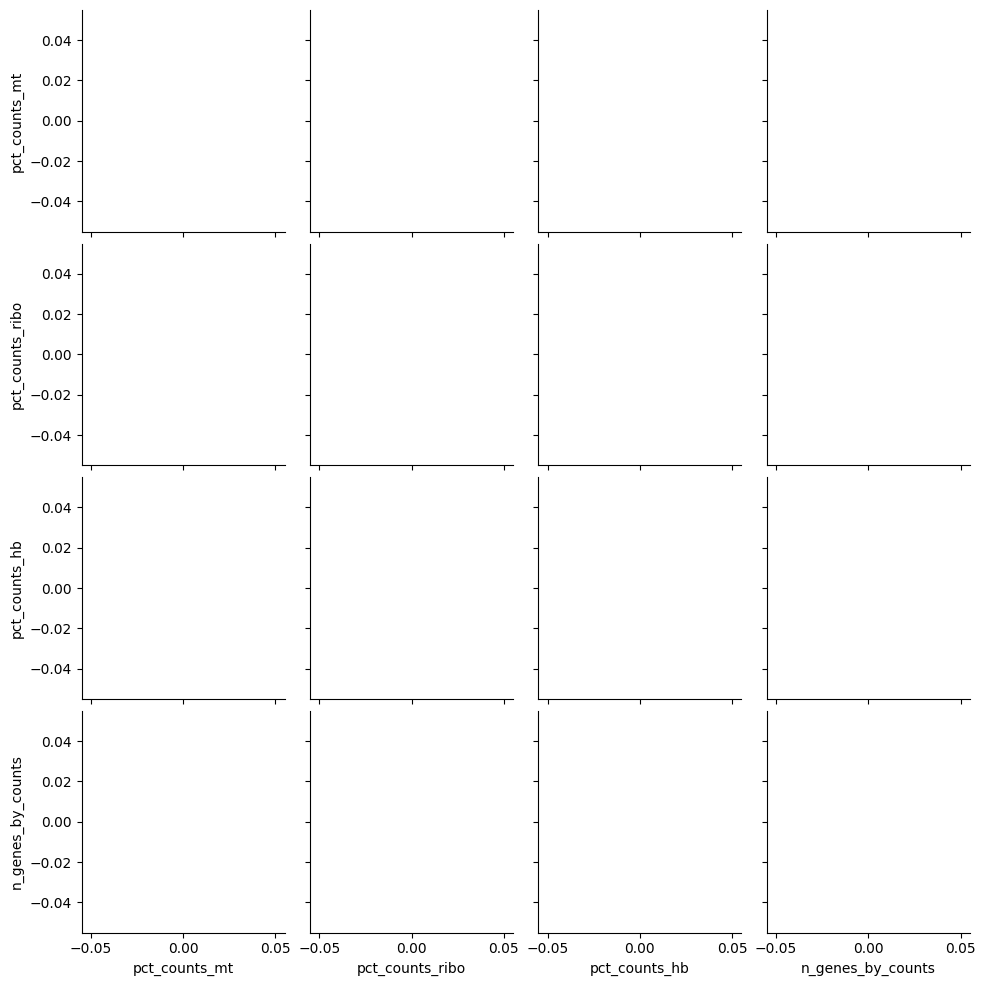

<Figure size 0x500 with 0 Axes>

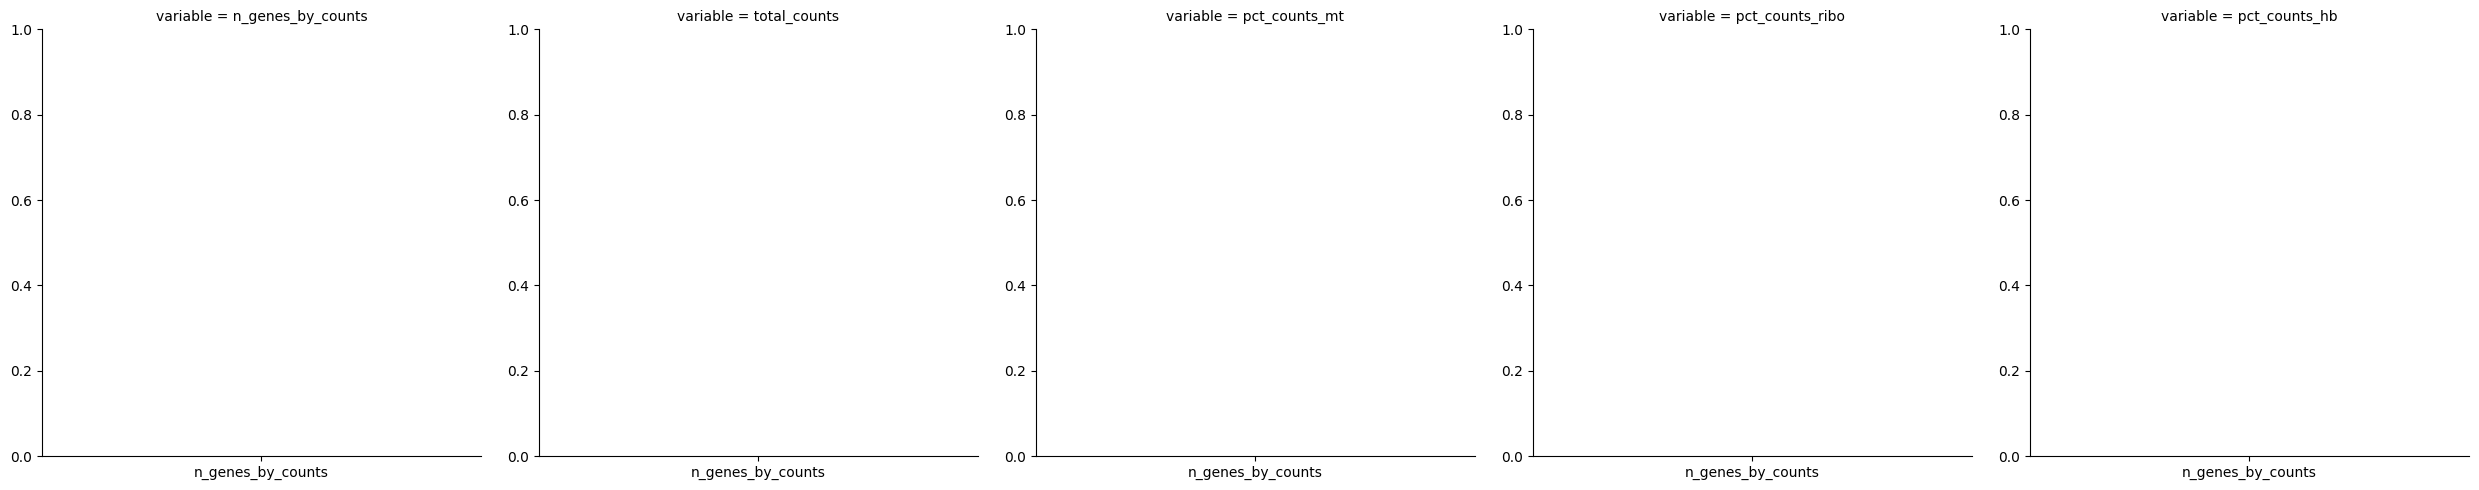

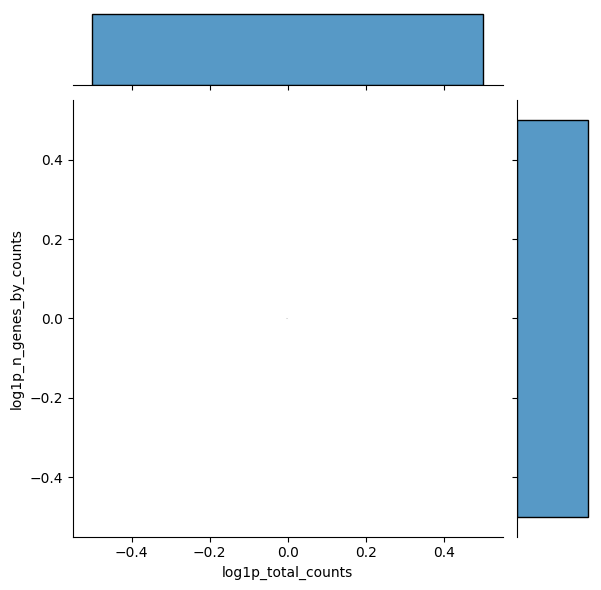

In [11]:
kws_multi = dict(kws_pp=kws_pp, kws_harmony=kws_harmony,
                 kws_cluster=kws_cluster)  # pre-integration processing
self = cr.Crispr(file_path, **kws_init, **kws_crispr, 
                 kws_multi=kws_multi)  # create object

# Clustering & Annotations

Clustering was conducted in the individual objects in `cr.pp.create_object_multi()`, but we want to re-do QC and clustering in the overall sample.

## Clustering

We need to have `kws_pca=False` so that the Harmony-adjusted PCA created during integration (rather than a newly-calculated one) will be used.

In [ ]:
self.cluster(**{**kws_cluster, "kws_pca": False}, layer="log1p")

## CellTypist

Annotate cell types.

In [ ]:
_ = self.annotate_clusters(model="COVID19_HumanChallenge_Blood.pkl")
self.rna.obs

# Plots

In [ ]:
cct = "predicted_labels" if "predicted_labels" in self.rna.obs else None
clus = list(self.rna.obs[cct].sample(2))  # clusters to circle
figs = self.plot(genes=36, 
                 kws_qc=True,
                 col_cell_type=cct,
                 layers="all",  # also plot "scaled" layer, for instance
                 kws_gex_violin=dict(scale="area", height=10),
                 kws_clustering=dict(col_cell_type=cct))

# Analyses

Perform perturbation-specific analyses.

## Augur

In [ ]:
cct = "majority_voting" if "majority_voting" in self.rna.obs else \
    self._columns["col_cell_type"]
_ = self.run_augur(
    col_cell_type=cct, 
    # ^ will be label in self._columns by default, but can override here
    col_perturbed=self._columns["col_perturbed"], 
    # ^ will be this by default if unspecified, but can override here
    key_treatment=self._keys["key_treatment"],  
    # ^ will be this by default if unspecified, but can override here
    select_variance_features=True,  # filter by highly variable genes
    classifier="random_forest_classifier", n_folds=3, augur_mode="default", 
    kws_umap=kws_umap, subsample_size=5, kws_augur_predict=dict(span=0.7))

## Mixscape

Classify perturbation "escapees," score perturbation responses, and find perturbation-based clusters.

In [ ]:
# col_split_by = self._columns["col_sample_id"]  # separate by sample
col_split_by = None  # calculate together
target_gene_idents = ["NOD2", "LACC1", "ATG16L1", "IL6ST"]  # plot these
_ = self.run_mixscape(col_split_by=col_split_by,
                      target_gene_idents=target_gene_idents)  # Mixscape

## Distance

Investigate distance metrics.

In [ ]:
_ = self.compute_distance(
    distance_type="edistance", method="X_pca", kws_plot=dict(
        figsize=(15, 15), robust=True), col_target_genes=self._columns[
            "col_guide_rna"] + "_original", layer="log1p")